# Data Science Capstone Project
This notebook's folium maps do not show correctly on Github. In order to view the maps, please review the original notebook at https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/ee0cf1a6-3e6e-4ac4-8ef6-30cb05c4811a/view?access_token=3bc10037fc8a7842ed018de476190560aa1a7e4a6e903d99c675105ebec107de

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

Using the BeautifulSoup package, scrape the Wikipedia page that contains the co-ordinate data of London and save the data into a dataframe

In [3]:
# locate relevant data on Wikipedia
source = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').text
soup = BeautifulSoup(source, 'lxml')
table = soup.find('table', class_='wikitable')

# create empty dataframe
coordinate_data = pd.DataFrame()

# copy data into the empty dataframe
for entry in table.find_all('tr'):
    line = pd.DataFrame([entry.text.splitlines()])
    coordinate_data = coordinate_data.append(line)

# remove unwanted columns
coordinate_data = coordinate_data[[1,17]]

# set correct column headers
coordinate_data.reset_index(drop=True, inplace=True)
coordinate_data.columns = coordinate_data.iloc[0]
coordinate_data = coordinate_data.drop([0]).reset_index(drop=True)

coordinate_data.head()

0                        Borough  \
0  Barking and Dagenham [note 1]   
1                         Barnet   
2                         Bexley   
3                          Brent   
4                        Bromley   

0                                       Co-ordinates  
0  51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...  
1  51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...  
2  51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...  
3  51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...  
4  51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...

Loop through the Co-ordinates column and return the latitude and longitude values

In [4]:
# initalise empty lists
Latitude = []
Longitude = []

# iterate through the 'Co-ordinates' column and return the lat and long values
for coord in coordinate_data['Co-ordinates']:
    Latitude.append(float(coord[47:54]))
    Longitude.append(float(coord[55:62]))

# add values as new columns to the dataframe
coordinate_data['Latitude'] = Latitude
coordinate_data['Longitude'] = Longitude

# now drop the old 'Co-ordinates' column
coordinate_data.drop('Co-ordinates', axis=1, inplace=True)
coordinate_data.head()

0                        Borough  Latitude  Longitude
0  Barking and Dagenham [note 1]   51.5607     0.1557
1                         Barnet   51.6252    -0.1510
2                         Bexley   51.4549     0.1505
3                          Brent   51.5588    -0.2810
4                        Bromley   51.4039     0.0198

In [5]:
# clean the 'Borough' column
coordinate_data['Borough'] = coordinate_data.Borough.str.replace(' \[note .\]','')
coordinate_data['Borough'] = coordinate_data['Borough'].apply(lambda x: x.strip())
coordinate_data.head()

0               Borough  Latitude  Longitude
0  Barking and Dagenham   51.5607     0.1557
1                Barnet   51.6252    -0.1510
2                Bexley   51.4549     0.1505
3                 Brent   51.5588    -0.2810
4               Bromley   51.4039     0.0198

Use Geolocator to get the geopgraphical coordinates of London.

In [6]:
!pip install geocoder
!pip install folium
import folium
import geocoder
from geopy.geocoders import Nominatim

     |████████████████████████████████| 102kB 13.6MB/s ta 0:00:01
     |████████████████████████████████| 92kB 7.4MB/s eta 0:00:011


In [7]:
address = 'London'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.5073219, -0.1276474.


In [8]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(coordinate_data['Latitude'], coordinate_data['Longitude'], coordinate_data['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

## London House Price Data

In [82]:
# fetch data and read into dataframe
prices_link = 'http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/England-annual-price-change-by-London-Borough-2019-12.csv?utm_medium=GOV.UK&utm_source=govuk&utm_campaign=England_annual_price_change_by_London_Borough_2019_12&utm_term=19_02_20&utm_content=web_page'
house_prices = pd.read_csv(prices_link, encoding='iso8859_15')
# drop irrelevant columns
house_prices.drop(['December 2018','Difference'], axis=1, inplace=True)
# rename columns
house_prices.rename(columns={'London borough':'Borough', 'December 2019':'Avg House Price'}, inplace=True)
# remove the '£' sign from the price data
house_prices['Avg House Price'] = house_prices['Avg House Price'].str.replace('£','')
# convert all prices to floats
house_prices['Avg House Price'] = house_prices['Avg House Price'].apply(lambda x: int(x))
# rename 'City of Westminster' to 'Westminster' to be in line with other data
house_prices.iloc[7,0] = 'Westminster'

house_prices

Borough  Avg House Price
0     Barking and Dagenham           303631
1                   Barnet           516896
2                   Bexley           341237
3                    Brent           505388
4                  Bromley           452429
5                   Camden           779779
6           City of London           738263
7              Westminster           984511
8                  Croydon           374089
9                   Ealing           472015
10                 Enfield           411794
11               Greenwich           400164
12                 Hackney           556223
13  Hammersmith and Fulham           699566
14                Haringey           562296
15                  Harrow           448263
16                Havering           367898
17              Hillingdon           403410
18                Hounslow           419024
19               Islington           629529
20  Kensington and Chelsea          1294907
21    Kingston upon Thames           488913
22                 Lambeth           519275
23                Lewisham           421701
24                  Merton           506341
25                  Newham           360691
26               Redbridge           434271
27    Richmond upon Thames           647672
28               Southwark           512669
29                  Sutton           373162
30           Tower Hamlets           457449
31          Waltham Forest           437867
32              Wandsworth           603883

In [80]:
house_prices.iloc[7,0]

'City of Westminster'

## Foursquare Venue Data
Foursquare credentials:

In [1]:
# The code was removed by Watson Studio for sharing.

We will use the Foursquare API to fetch the top 100 venues with a defined radius from each borough centre. The smallest borough in the dataset is the Borough of Kensington and Chelsea with an area of 12.13 km2. If the borough were a perfect circle, it's radius would be sqrt(12.13/π) = 1960m. As the borough is not a perfect circle, we will search for venues within a 1500m limit.

In [82]:
# set area radius and number of venues limit
radius = 1500
LIMIT = 100

In [3]:
# Function that extracts the category of the venue:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [4]:
# Function to get venue infomation for all neighbourhoods in London:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
# Running the above function on each neighborhood and creating a new dataframe called london_venues:
london_venues = getNearbyVenues(names=coordinate_data['Borough'],
                                   latitudes=coordinate_data['Latitude'],
                                   longitudes=coordinate_data['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [95]:
# save toronto_venues to csv for future use to prevent repeat API requests:
project.save_data(file_name = "london_venues.csv",data = london_venues.to_csv(index=False), overwrite=True)

{'file_name': 'london_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdatasciencecapstoneproject-donotdelete-pr-fzpo45gg751c0q',
 'asset_id': '488f091a-bc97-42a8-8bbb-1e84648dec13'}

In [7]:
# code to open the file if needed
london_venues = project.get_file(file_name = "london_venues.csv")
london_venues = pd.read_csv(london_venues)
print(london_venues.shape)
london_venues.head()

(2481, 7)


Borough  Borough Latitude  Borough Longitude         Venue  \
0  Barking and Dagenham           51.5607             0.1557  Central Park   
1  Barking and Dagenham           51.5607             0.1557    Lara Grill   
2  Barking and Dagenham           51.5607             0.1557       Iceland   
3  Barking and Dagenham           51.5607             0.1557         Shell   
4  Barking and Dagenham           51.5607             0.1557          Asda   

   Venue Latitude  Venue Longitude      Venue Category  
0       51.559560         0.161981                Park  
1       51.562445         0.147178  Turkish Restaurant  
2       51.560578         0.147685       Grocery Store  
3       51.560415         0.148364         Gas Station  
4       51.565751         0.143392         Supermarket

In [94]:
london_venues.groupby('Borough').count()
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 261 uniques categories.


## Data Processing
First, let's check for boroughs without enough venue information.

In [4]:
london_venues.Borough.value_counts().to_frame().tail(10)

Borough
Bexley                     60
Newham                     60
Hillingdon                 53
Harrow                     51
Sutton                     51
Redbridge                  50
Lewisham                   47
Merton                     37
Barnet                     21
Barking and Dagenham       19

It is clear that Barking and Dagenham, Barnet and Merton do not have enough venue references to form a meaningful analysis, so these boroughs will be removed.

In [8]:
london_venues = london_venues[(london_venues.Borough!='Barking and Dagenham') & (london_venues.Borough!='Barnet') & (london_venues.Borough!='Merton')]

In [9]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = london_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

Borough  Afghan Restaurant  African Restaurant  Airport  Airport Service  \
40  Bexley                  0                   0        0                0   
41  Bexley                  0                   0        0                0   
42  Bexley                  0                   0        0                0   
43  Bexley                  0                   0        0                0   
44  Bexley                  0                   0        0                0   

    American Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
40                    0                       0            0           0   
41                    0                       0            0           0   
42                    0                       0            0           0   
43                    0                       0            0           0   
44                    1                       0            0           0   

    Arts & Crafts Store  ...  Turkish Restaurant  \
40                    0  ...                   0   
41                    0  ...                   0   
42                    0  ...                   0   
43                    0  ...                   0   
44                    0  ...                   0   

    Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
40                              0                 0                      0   
41                              0                 0                      0   
42                              0                 0                      0   
43                              0                 0                      0   
44                              0                 0                      0   

    Warehouse Store  Windmill  Wine Bar  Wine Shop  Women's Store  Yoga Studio  
40                0         0         0          0              0            0  
41                0         0         0          0              0            0  
42                0         0         0          0              0            0  
43                0         0         0          0              0            0  
44                0         0         0          0              0            0  

[5 rows x 258 columns]

Now we can group the rows by borough and take the mean of the frequency of occurrence of each category.

In [10]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped.head()

Borough  Afghan Restaurant  African Restaurant  Airport  Airport Service  \
0   Bexley                0.0                 0.0      0.0              0.0   
1    Brent                0.0                 0.0      0.0              0.0   
2  Bromley                0.0                 0.0      0.0              0.0   
3   Camden                0.0                 0.0      0.0              0.0   
4  Croydon                0.0                 0.0      0.0              0.0   

   American Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0             0.033333                     0.0         0.00         0.0   
1             0.020000                     0.0         0.00         0.0   
2             0.016129                     0.0         0.00         0.0   
3             0.000000                     0.0         0.01         0.0   
4             0.000000                     0.0         0.00         0.0   

   Arts & Crafts Store  ...  Turkish Restaurant  \
0             0.000000  ...            0.000000   
1             0.000000  ...            0.000000   
2             0.000000  ...            0.016129   
3             0.000000  ...            0.010000   
4             0.011236  ...            0.000000   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                           0.00          0.016667                   0.00   
1                           0.00          0.000000                   0.00   
2                           0.00          0.000000                   0.00   
3                           0.01          0.000000                   0.01   
4                           0.00          0.000000                   0.00   

   Warehouse Store  Windmill  Wine Bar  Wine Shop  Women's Store  Yoga Studio  
0         0.016667       0.0      0.00        0.0            0.0          0.0  
1         0.020000       0.0      0.00        0.0            0.0          0.0  
2         0.000000       0.0      0.00        0.0            0.0          0.0  
3         0.000000       0.0      0.01        0.0            0.0          0.0  
4         0.000000       0.0      0.00        0.0            0.0          0.0  

[5 rows x 258 columns]

## Comparing the top 10 venues for each borough.

In [11]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
# creating a new dataframe and displaying the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

Borough 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0   Bexley                   Pub  Fast Food Restaurant           Coffee Shop   
1    Brent           Coffee Shop                 Hotel        Clothing Store   
2  Bromley                   Pub           Coffee Shop        Clothing Store   
3   Camden           Coffee Shop                  Café           Pizza Place   
4  Croydon                   Pub           Coffee Shop        Clothing Store   

      4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Clothing Store           Supermarket    Italian Restaurant   
1                       Bar     Indian Restaurant        Sandwich Place   
2               Supermarket           Pizza Place  Gym / Fitness Center   
3                     Hotel        Breakfast Spot        History Museum   
4  Mediterranean Restaurant                  Park     Indian Restaurant   

  7th Most Common Venue 8th Most Common Venue  9th Most Common Venue  \
0         Grocery Store                 Hotel    American Restaurant   
1         Grocery Store    Italian Restaurant            Supermarket   
2     Indian Restaurant                  Park      Electronics Store   
3               Exhibit          Burger Joint              Bookstore   
4             Bookstore    Italian Restaurant  Portuguese Restaurant   

  10th Most Common Venue  
0               Pharmacy  
1            Pizza Place  
2                    Bar  
3               Beer Bar  
4       Sushi Restaurant

## K-means Clustering
We will use the k-means algorithm to cluster the boroughs. First we will use the elbow method to determine the optimal value for k.

Text(0, 0.5, 'Error')

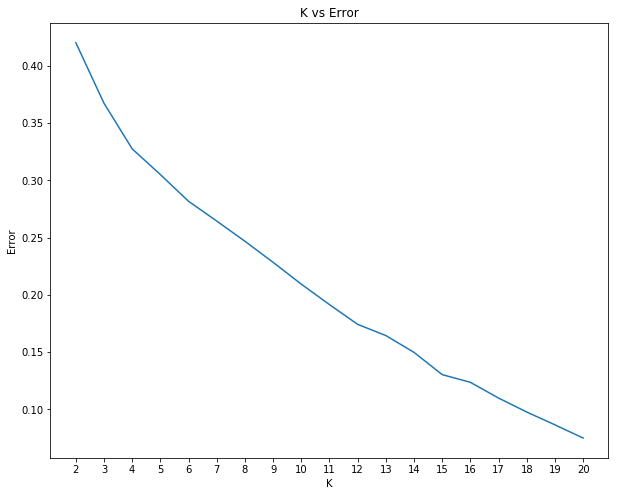

In [22]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

london_grouped_clustering = london_grouped.drop('Borough', 1)

def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=0)
    km.fit(london_grouped_clustering)
    return km.inertia_

scores = [get_inertia(x) for x in range(2, 21)]

plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

As can be seen from the above graph, the optimal value for k is three: the 'elbow' point on the graph.  
We can now run the k-means clustering algorithm on the dataset.

In [23]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 2, 3, 2, 0, 2, 2, 0, 0], dtype=int32)

In [105]:
# add clustering labels
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = coordinate_data
london_merged = coordinate_data[(coordinate_data.Borough!='Barking and Dagenham') & (coordinate_data.Borough!='Barnet') & (coordinate_data.Borough!='Merton')]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough').reset_index(drop=True)

london_merged.head() # check the last columns!

Borough Area (sq mi)  Latitude  Longitude  Cluster Labels  \
0   Bexley        23.38   51.4549     0.1505               2   
1    Brent        16.70   51.5588    -0.2810               1   
2  Bromley        57.97   51.4039     0.0198               2   
3   Camden         8.40   51.5290    -0.1250               3   
4  Croydon        33.41   51.3714    -0.0970               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Pub  Fast Food Restaurant           Coffee Shop   
1           Coffee Shop                 Hotel        Clothing Store   
2                   Pub           Coffee Shop        Clothing Store   
3           Coffee Shop                  Café           Pizza Place   
4                   Pub           Coffee Shop        Clothing Store   

      4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Clothing Store           Supermarket    Italian Restaurant   
1                       Bar     Indian Restaurant        Sandwich Place   
2               Supermarket           Pizza Place  Gym / Fitness Center   
3                     Hotel        Breakfast Spot        History Museum   
4  Mediterranean Restaurant                  Park     Indian Restaurant   

  7th Most Common Venue 8th Most Common Venue  9th Most Common Venue  \
0         Grocery Store                 Hotel    American Restaurant   
1         Grocery Store    Italian Restaurant            Supermarket   
2     Indian Restaurant                  Park      Electronics Store   
3               Exhibit          Burger Joint              Bookstore   
4             Bookstore    Italian Restaurant  Portuguese Restaurant   

  10th Most Common Venue  
0               Pharmacy  
1            Pizza Place  
2                    Bar  
3               Beer Bar  
4       Sushi Restaurant

We can also estimate the number of most common venues in each cluster. We can then create a bar chart which will help us to visualise the findings and give proper label names to each cluster.

In [49]:
count_venue = london_merged
count_venue = count_venue.drop(['Borough','Area (sq mi)', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can create a pivot table to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster.rename_axis('Cluster Label', axis='columns', inplace=True)
cv_cluster

Cluster Label  Café  Clothing Store  Coffee Shop  Grocery Store  Hotel  \
0                 1               0            1              0      0   
1                 0               0            2              0      0   
2                 0               1            2              1      0   
3                 0               0            3              0      2   

Cluster Label  Indian Restaurant  Pub  
0                              0    8  
1                              1    0  
2                              0    7  
3                              0    0

Text(0, 0.5, 'Number of Venues')

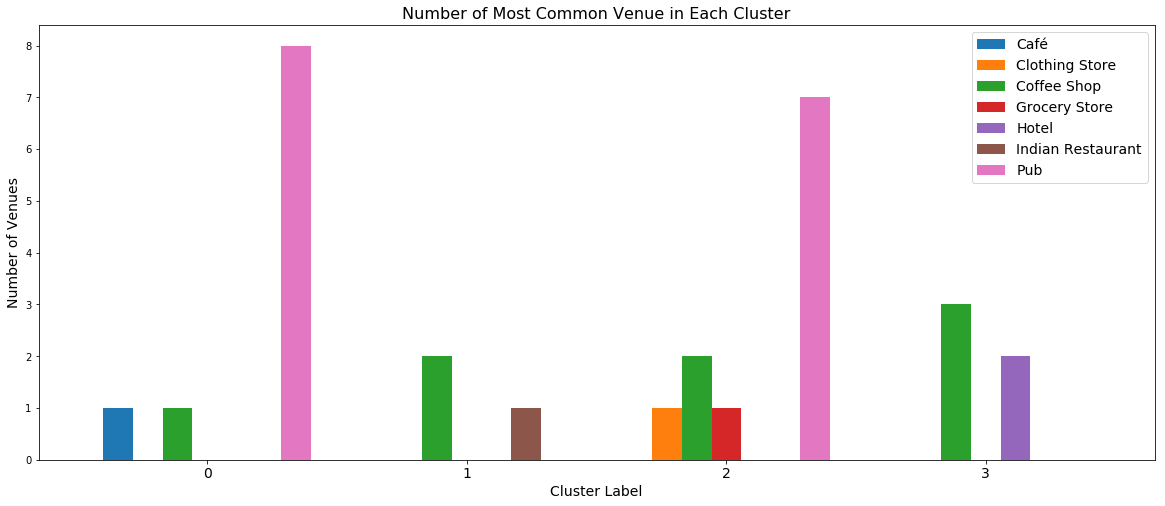

In [52]:
#creating a bar chart
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Most Common Venue in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Cluster Label', fontsize=14)
plt.ylabel('Number of Venues', fontsize=14)

In [63]:
count_venue2 = london_merged
count_venue2 = count_venue2.drop(['Borough','Area (sq mi)', 'Latitude', 'Longitude'], axis=1)
count_venue2 = count_venue2.groupby(['Cluster Labels','2nd Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster2 = count_venue2.pivot(index='Cluster Labels', columns='2nd Most Common Venue', values='Counts')
cv_cluster2 = cv_cluster2.fillna(0).astype(int).reset_index(drop=True)
cv_cluster2.rename_axis('Cluster Label', axis='columns', inplace=True)
cv_cluster2

Cluster Label  Burger Joint  Café  Clothing Store  Coffee Shop  \
0                         0     3               0            4   
1                         0     0               0            0   
2                         0     0               1            5   
3                         1     1               0            2   

Cluster Label  Fast Food Restaurant  Grocery Store  Hotel  Indian Restaurant  \
0                                 0              0      0                  0   
1                                 0              0      2                  1   
2                                 1              2      0                  0   
3                                 0              0      1                  0   

Cluster Label  Pizza Place  Pub  Supermarket  
0                        1    2            0  
1                        0    0            0  
2                        0    1            1  
3                        0    0            0

Text(0, 0.5, 'Number of Venues')

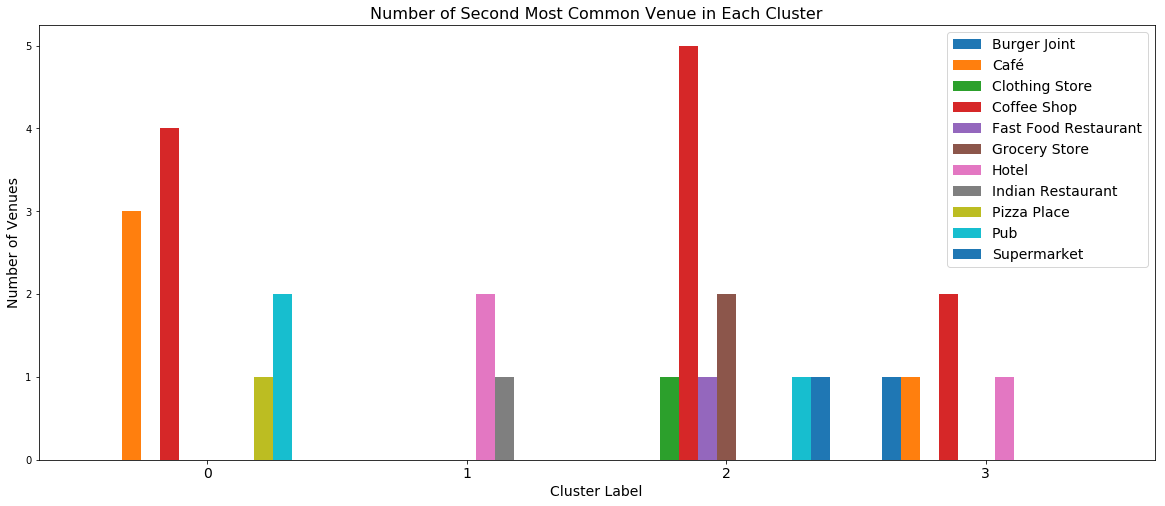

In [64]:
#creating a bar chart
frame=cv_cluster2.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster2.columns,fontsize= 14)
plt.title("Number of Second Most Common Venue in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Cluster Label', fontsize=14)
plt.ylabel('Number of Venues', fontsize=14)

By visualising the most common venues in each cluster, we can assign a descriptive label to each cluster: 
* Cluster 0: Pubs and cafes.
* Cluster 1: Indian restaurants and cafes/hotels.
* Cluster 2: Pubs, cafes, food and clothes.
* Cluster 3: Coffee and hotels.

In [128]:
cluster_labels = {'Cluster Labels': [0,1,2,3], 'Description': ["Pubs and cafes","Indian restaurants and cafes/hotels","Pubs, cafes, food and clothes","Cafes and hotels"]}
cluster_labels = pd.DataFrame(data=cluster_labels)
cluster_labels

Cluster Labels                          Description
0               0                       Pubs and cafes
1               1  Indian restaurants and cafes/hotels
2               2        Pubs, cafes, food and clothes
3               3                     Cafes and hotels

In [138]:
# The code was removed by Watson Studio for sharing.

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
1      Brent               1           Coffee Shop                 Hotel   
11    Harrow               1           Coffee Shop     Indian Restaurant   
14  Hounslow               1     Indian Restaurant                 Hotel   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1         Clothing Store                   Bar     Indian Restaurant   
11        Sandwich Place                   Bar                   Gym   
14         Grocery Store  Fast Food Restaurant        Clothing Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1         Sandwich Place         Grocery Store    Italian Restaurant   
11  Fast Food Restaurant                  Park        Clothing Store   
14           Coffee Shop                  Park        Sandwich Place   

   9th Most Common Venue 10th Most Common Venue  
1            Supermarket            Pizza Place  
11                   Pub         Chocolate Shop  
14           Supermarket               Pharmacy

We can create a dataframe that lists the top three venues in each borough. This will be used as a label when mapping the clusters

In [172]:
top3 = london_venues.groupby(['Borough','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Borough','Counts'],ascending=False).groupby('Borough').head(3).reset_index(drop=True)

top3['Top 3 Venues'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Borough'])['Top 3 Venues'].apply(", ".join).reset_index()

top3.head()

Borough                                     Top 3 Venues
0   Bexley  9 Pub, 5 Fast Food Restaurant, 4 Clothing Store
1    Brent         8 Coffee Shop, 7 Clothing Store, 7 Hotel
2  Bromley           6 Pub, 5 Coffee Shop, 4 Clothing Store
3   Camden                  10 Coffee Shop, 6 Café, 5 Hotel
4  Croydon          10 Pub, 9 Coffee Shop, 6 Clothing Store

## Mapping Clusters

In [173]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top_3 in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Borough'], london_merged['Cluster Labels'], top3['Top 3 Venues']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' // Top three venues: ' + str(top_3), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Exploring House Price Data
Let's first create a histogram of house prices with five bins.

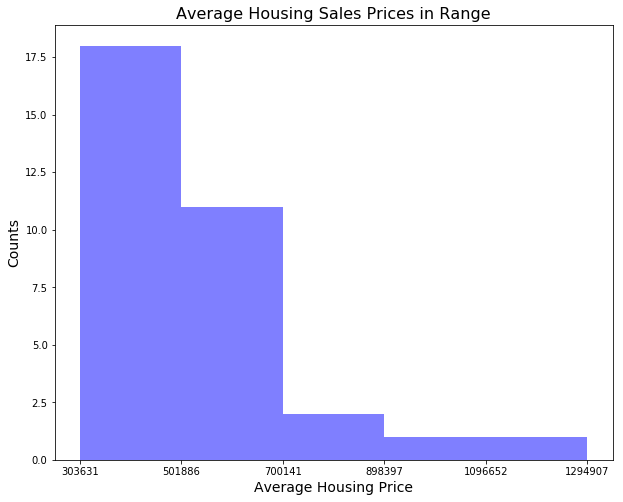

Bin Edges: [ 303631.   501886.2  700141.4  898396.6 1096651.8 1294907. ]


In [85]:
bins, bin_edges = np.histogram(house_prices['Avg House Price'], bins=5)
num_bins = len(bins)
plt.figure(figsize=[10, 8])
n, bins, patches = plt.hist(house_prices['Avg House Price'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Average Housing Sales Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(bin_edges, fontsize=10)
plt.xticks(rotation=0)
plt.xlabel('Average Housing Price', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()
print('Bin Edges:',bin_edges)

We can use the historam bins to create labels and add these to our house prices dataframe. These labels will be used later on when creating the cluster map.

In [86]:
level = []
for i in range(0,len(house_prices)):
    if house_prices['Avg House Price'][i] < bin_edges[1]:
        level.append('Low')
    elif house_prices['Avg House Price'][i] >= bin_edges[1] and house_prices['Avg House Price'][i] < bin_edges[2]:
        level.append('Lower Mid')
    elif house_prices['Avg House Price'][i] >= bin_edges[2] and house_prices['Avg House Price'][i] < bin_edges[3]:
        level.append('Upper Mid')
    elif house_prices['Avg House Price'][i] >= bin_edges[3] and house_prices['Avg House Price'][i] < bin_edges[4]:
        level.append('High')
    else:
        level.append('Very High')

house_prices['Price Level'] = level
print(house_prices['Price Level'].value_counts())
house_prices.head()

Low          18
Lower Mid    11
Upper Mid     2
Very High     1
High          1
Name: Price Level, dtype: int64


Borough  Avg House Price Price Level
0  Barking and Dagenham           303631         Low
1                Barnet           516896   Lower Mid
2                Bexley           341237         Low
3                 Brent           505388   Lower Mid
4               Bromley           452429         Low

## Creating Labels for Map

In [129]:
df_labels = coordinate_data
# first remove the boroughs without enough venue data
df_labels = df_labels[(df_labels.Borough!='Barking and Dagenham') & (df_labels.Borough!='Barnet') & (df_labels.Borough!='Merton')].reset_index(drop=True)
# add the top 3 venues
df_labels = df_labels.join(top3.set_index('Borough'), on='Borough')
# add the house price level
df_labels = df_labels.join(house_prices.set_index('Borough'), on='Borough').drop('Avg House Price', axis=1)
# add the cluster labels
df_labels = df_labels.join(london_merged[['Borough','Cluster Labels']].set_index('Borough'), on='Borough')
# add the cluster description
df_labels = df_labels.join(cluster_labels.set_index('Cluster Labels'), on='Cluster Labels')
df_labels.head()

Borough  Latitude  Longitude  \
0   Bexley   51.4549     0.1505   
1    Brent   51.5588    -0.2810   
2  Bromley   51.4039     0.0198   
3   Camden   51.5290    -0.1250   
4  Croydon   51.3714    -0.0970   

                                      Top 3 Venues Price Level  \
0  9 Pub, 5 Fast Food Restaurant, 4 Clothing Store         Low   
1         8 Coffee Shop, 7 Clothing Store, 7 Hotel   Lower Mid   
2           6 Pub, 5 Coffee Shop, 4 Clothing Store         Low   
3                  10 Coffee Shop, 6 Café, 5 Hotel   Upper Mid   
4          10 Pub, 9 Coffee Shop, 6 Clothing Store         Low   

   Cluster Labels                          Description  
0               2        Pubs, cafes, food and clothes  
1               1  Indian restaurants and cafes/hotels  
2               2        Pubs, cafes, food and clothes  
3               3                     Cafes and hotels  
4               2        Pubs, cafes, food and clothes

## Map of House Prices

In [70]:
!wget --quiet https://raw.githubusercontent.com/blackmad/neighborhoods/master/london.geojson
    
# https://github.com/blackmad/neighborhoods/blob/master/london.geojson
print('GeoJSON file downloaded!')

london_geo = r'london.geojson'

# London La, Lo
latitude = 51.5073219
longitude = -0.1276474

GeoJSON file downloaded!


In [171]:
# display London
london_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# cholopleth map
london_map.choropleth(
    geo_data=london_geo,
    data=house_prices,
    columns=['Borough','Avg House Price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='House Sales Price in London',
    highlight=True
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top3, cluster_number, price in zip(df_labels['Latitude'], df_labels['Longitude'], df_labels['Borough'], df_labels['Description'], df_labels['Top 3 Venues'], df_labels['Cluster Labels'], df_labels['Price Level']):
    label = folium.Popup(str(poi) + " \n Description:" + str(cluster) + " \n -- Price level: " + str(price) + " \n -- Top 3 venues:" + str(top3), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(london_map)
       

# display map
london_map